In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-10-01 11:39:48.162254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 11:39:48.162346: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
White_Island_data = pd.read_csv('WhiteIsland_2019_data.csv')

White_Island_data.index = White_Island_data['Times'] #make Time the index row of the dataframe
White_Island_data.pop('Times') #drop the original times column
White_Island_data

,Data
Times,
0.0000,-1.297929e-04
0.0125,-9.454767e-05
0.0250,-2.799090e-06
0.0375,4.928769e-05
0.0500,8.076214e-05
...,...
50399.9375,-2.401038e-07
50399.9500,4.512536e-07
50399.9625,-9.769601e-07


<AxesSubplot:xlabel='Times', ylabel='Velocity (m/s)'>

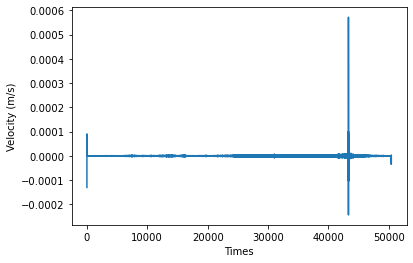

In [3]:
Velocity = White_Island_data['Data']
Velocity.plot(ylabel = 'Velocity (m/s)')

In [4]:
# Slice [start:stop:step], starting from index 100 take every X th record. Time is is seconds.

# df = df[0::1000] #10 secondly predictions (every 10 seconds)
# df = df[100::6000] #minutely predictions (every 1 minute)
White_Island_data_adj = White_Island_data[500:50300:]
# df = df[0::60*6000] #hourly predictions (every 1 hour)

#df.Times = pd.to_datetime(df.Times) #Convert UTC to datetime

White_Island_data_adj

,Data
Times,
500.0000,6.660453e-08
500.0125,1.729838e-07
500.0250,2.744279e-07
500.0375,3.950074e-07
500.0500,4.313084e-07
...,...
50299.9500,-7.962168e-08
50299.9625,-5.522008e-08
50299.9750,-2.321078e-08


<AxesSubplot:xlabel='Times', ylabel='Velocity (m/s)'>

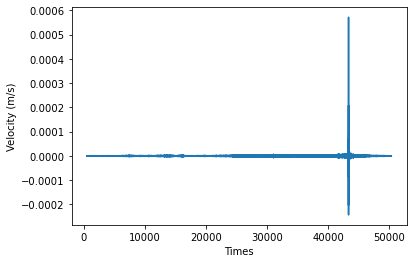

In [5]:
Velocity = White_Island_data_adj['Data']
Velocity.plot(ylabel = 'Velocity (m/s)')

## Split the data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. It's important to note that the data is not being randomly shuffled before splitting. This is for two reasons:

   1. It ensures that chopping the data into windows of consecutive samples is still possible.
   2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [6]:
column_indices = {name: i for i, name in enumerate(White_Island_data_adj.columns)}

n = len(Velocity)

train_White_Island_data = Velocity[:35140]
val_White_Island_data = Velocity[35140:40180]
#val_White_Island_data = Velocity[35140:45180]
test_White_Island_data = Velocity[40180:]

#num_features = Velocity.shape[1]

## Normalize the Input

In order to work with this data, it is useful to first normalize the input (to the interval between 0 and 1):

Firstly, Calculate the average and the Standard Deviation:

In [7]:
train_mean, train_std = train_White_Island_data.mean(), train_White_Island_data.std()

We then subtract the Mean and divide by the Standard Deviation:

In [8]:
train_Velocity = (train_White_Island_data - train_mean) / train_std
val_Velocity = (val_White_Island_data - train_mean) / train_std
test_Velocity = (test_White_Island_data - train_mean) / train_std

This is a typical z-score normalisation. So examining the graph, the plot looks exactly the same as before. This is because normalization does not change the shape of the data. The purpose of z-score normailisation make sures that the mean is now centered around zero and the standard deviation of the data is now 1.

<AxesSubplot:xlabel='Times', ylabel='Velocity (m/s)'>

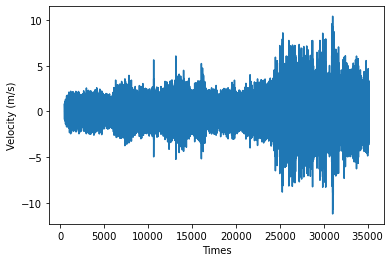

In [9]:
Velocity = train_Velocity 
Velocity.plot(ylabel = 'Velocity (m/s)')

### Data windowing

In [10]:
#Converting a forecasting learning problem to a supervised learning problem

def df_to_X_y(df, window_size=5): #Where the X is going to be your input values and y is your output value
  df_as_np = df.to_numpy()        #convert the df to numpy
  X = []                          #create list X
  y = []                          #create list y
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]] #Take the values from i to i+window(not including itself)
    X.append(row)
    label = df_as_np[i+window_size] #true actually value for that input row
    y.append(label)
  return np.array(X), np.array(y) #convert lists into arrays using np.array

In [11]:
WINDOW_SIZE = 5 #Choose the window size


#Training set
X_train1, y_train1 = df_to_X_y(train_Velocity, WINDOW_SIZE) #Feed the window Size and the Velocity Values into the Window Class


#Valadation set
X_val1, y_val1 = df_to_X_y(val_Velocity, WINDOW_SIZE) #Feed the window Size and the Velocity Values into the Window Class


#Test set
X_test1, y_test1 = df_to_X_y(test_Velocity, WINDOW_SIZE) #Feed the window Size and the Velocity Values into the Window Class


#print shape of each
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape #output the shapes of everything


((2771196, 5, 1),
 (2771196,),
 (403196, 5, 1),
 (403196,),
 (809596, 5, 1),
 (809596,))

# Building the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint #For saving models, Saving model that does best on the validation
from tensorflow.keras.losses import MeanSquaredError #loss function, so it's the mean squared error
#mean squared error is the sum the mean squared error we sum over the square distances between the actual value
from tensorflow.keras.metrics import RootMeanSquaredError #squareroot for the root mean squared error.
from tensorflow.keras.optimizers import Adam

#using the sequential API, let's make out model

model1 = Sequential()
model1.add(InputLayer((5, 1))) #specify the shape of the input layer, 5 x 1 vector
model1.add(LSTM(64))           #Pass into the complex Recurrent Neural Network (could also use gru if you wanted too)
model1.add(Dense(8, 'tanh'))   #Convert to 8 tanh's
model1.add(Dense(1, 'linear')) #We want a linear value, we're trying to predict some velocity which is going to be positive or negative value

model1.summary()

2022-10-01 11:44:19.906048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-01 11:44:19.909222: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-01 11:44:19.915176: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patrick-OptiPlex-7020): /proc/driver/nvidia/version does not exist
2022-10-01 11:44:19.975046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [13]:
cp1 = ModelCheckpoint('model1/', save_best_only=True) #I want to only save the best model which is going to be defined automatically by saving the one that has the lowest validation loss
model1.compile(loss=MeanSquaredError(), 
               optimizer=Adam(learning_rate=0.0001), 
               metrics=[RootMeanSquaredError()])
#Learning rate = the higher this number is the faster the model is going to try and decrease the loss but we don't want to decrease super super quickly otherwise it's not going to find its maximum or the local minimum

In [14]:
history = model1.fit(X_train1, y_train1,
                     validation_data=(X_val1, y_val1),
                     epochs=10,
                     callbacks=[cp1])

#fit the model by passing it the training data and the validation data
#epoch means the number of runs through the dataset for the training data
# callback: this function calls back cp to see if it wants to save the model depending on if the model if the validation loss was higher or lower than it was before it's only going to save it based off of the absolute minimum that it's seen validation loss

Epoch 1/10
86590/86600 [============================>.] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1334

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 160s 2ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1499
Epoch 2/10
86600/86600 [==============================] - 161s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 3/10
86592/86600 [============================>.] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1068

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 165s 2ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483
Epoch 4/10
86599/86600 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1065

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 165s 2ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 5/10
86586/86600 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1062

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 167s 2ms/step - loss: 0.0113 - root_mean_squared_error: 0.1062 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1478
Epoch 6/10
86589/86600 [============================>.] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.1060

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 165s 2ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 7/10
86582/86600 [============================>.] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.1057

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 159s 2ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1460
Epoch 8/10
86587/86600 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1055

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 159s 2ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 9/10
86585/86600 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1053

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 158s 2ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1451
Epoch 10/10
86583/86600 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1051

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


86600/86600 [==============================] - 159s 2ms/step - loss: 0.0111 - root_mean_squared_error: 0.1051 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446


In [13]:
# load back the one that had the lowest validation loss and we do that with

from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [14]:
# make 3 pandas data frame (for train, validation and test)
# just showing where all the trains predictions are compared to the actual label 

train_predictions = model1.predict(X_train1).flatten() #.flatten to convert the vector of predictions into a list
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1}) # create dataframe and label columns
train_results

86600/86600 [==============================] - 240s 3ms/step


,Train Predictions,Actuals
0,0.622615,0.661183
1,0.647521,0.590583
2,0.486905,0.461370
3,0.315110,0.375782
4,0.311615,0.361662
...,...,...
2771191,1.027889,1.016525
2771192,0.860430,1.338503
2771193,1.747725,1.516668
2771194,1.370922,1.169766


In [15]:
train_results_difference = abs(train_results.diff(axis=1))

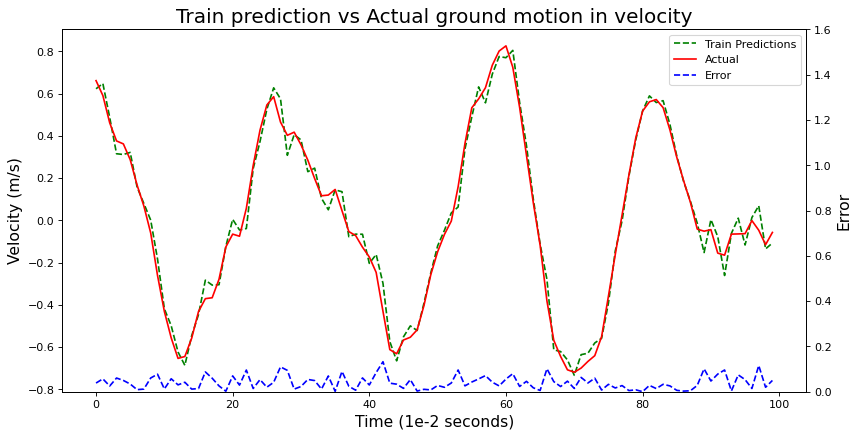

In [16]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6), dpi=80)

Train_Predictions = ax1.plot((train_results['Train Predictions'][:100]),
                             color='green', linestyle='dashed', label= 'Train Predictions')
Actuals = ax1.plot((train_results['Actuals'][:100]),
                   color='red', linestyle='solid', label = 'Actual')
ax1.set_xlabel('Time (1e-2 seconds)',fontsize = 14)
ax1.set_ylabel('Velocity (m/s)',fontsize = 14)

ax2 = ax1.twinx()
Error = ax2.plot((train_results_difference['Actuals'][:100]),
                 color='blue', linestyle='dashed', label = 'Error')
ax2.set_ylabel('Error', fontsize = 14)
ax2.set_ylim(0,1.6)

lines = Train_Predictions + Actuals + Error
labels = [l.get_label() for l in lines]
ax2.legend(lines,labels)

plt.title('Train prediction vs Actual ground motion in velocity', fontsize = 18)

fig.savefig('Train prediction vs Actual ground motion in velocity.png')

In [17]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results_difference = abs(val_results.diff(axis=1))
val_results

12600/12600 [==============================] - 35s 3ms/step


,Val Predictions,Actuals
0,0.237022,-0.137218
1,-0.891595,-0.694909
2,-0.733732,-0.919631
3,-1.131677,-1.170354
4,-1.460776,-1.348751
...,...,...
403191,1.937187,2.033150
403192,1.654962,1.784189
403193,1.444351,1.630798
403194,1.259696,1.306087


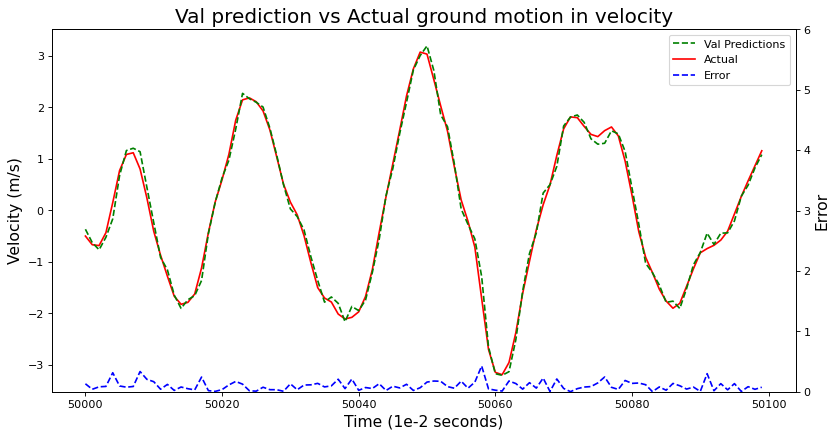

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=80)

Actuals = ax1.plot((val_results['Actuals'][50000:50100]),
                   color='red', linestyle='solid', label = 'Actual')
Train_Predictions = ax1.plot((val_results['Val Predictions'][50000:50100]),
                             color='green', linestyle='dashed', label= 'Val Predictions')
ax1.set_xlabel('Time (1e-2 seconds)',fontsize = 14)
ax1.set_ylabel('Velocity (m/s)',fontsize = 14)
#ax1.set_ylim(-20,20)

ax2 = ax1.twinx()
Error = ax2.plot((val_results_difference['Actuals'][50000:50100]),
                 color='blue', linestyle='dashed', label = 'Error')
ax2.set_ylabel('Error',fontsize = 14)
ax2.set_ylim(0,6)

lines = Train_Predictions + Actuals + Error
labels = [l.get_label() for l in lines]
ax2.legend(lines,labels)

plt.title('Val prediction vs Actual ground motion in velocity',fontsize = 18)

fig.savefig('Validation prediction vs Actual ground motion in velocity.png')

In [19]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results_difference = abs(test_results.diff(axis=1))
test_results

25300/25300 [==============================] - 71s 3ms/step


,Test Predictions,Actuals
0,-2.745851,-2.923961
1,-3.230172,-3.136276
2,-3.081177,-2.751458
3,-1.945664,-1.993156
4,-1.276395,-1.470127
...,...,...
809591,-0.075998,-0.124722
809592,-0.133817,-0.086499
809593,-0.002673,-0.036359
809594,0.003585,-0.018670


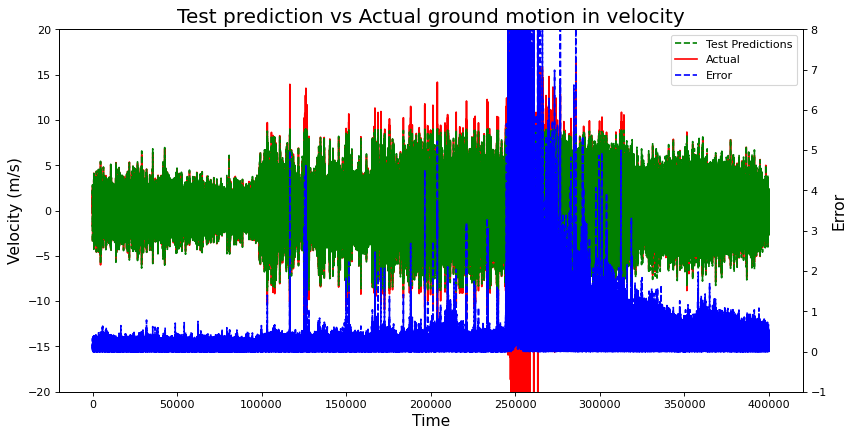

In [25]:
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=80)

Actuals = ax1.plot((test_results['Actuals'][:400000]),
                   color='red', linestyle='solid', label = 'Actual')
Train_Predictions = ax1.plot((test_results['Test Predictions'][:400000]),
                             color='green', linestyle='dashed', label= 'Test Predictions')
ax1.set_xlabel('Time',fontsize = 14)
ax1.set_ylabel('Velocity (m/s)',fontsize = 14)
ax1.set_ylim(-20,20)

ax2 = ax1.twinx()
Error = ax2.plot((test_results_difference['Actuals'][:400000]),
                 color='blue', linestyle='dashed', label = 'Error')
ax2.set_ylabel('Error',fontsize = 14)
ax2.set_ylim(-1,8)

lines = Train_Predictions + Actuals + Error
labels = [l.get_label() for l in lines]
ax2.legend(lines,labels)

plt.title('Test prediction vs Actual ground motion in velocity',fontsize = 18)

fig.savefig('Test prediction vs Actual ground motion in velocity.png')

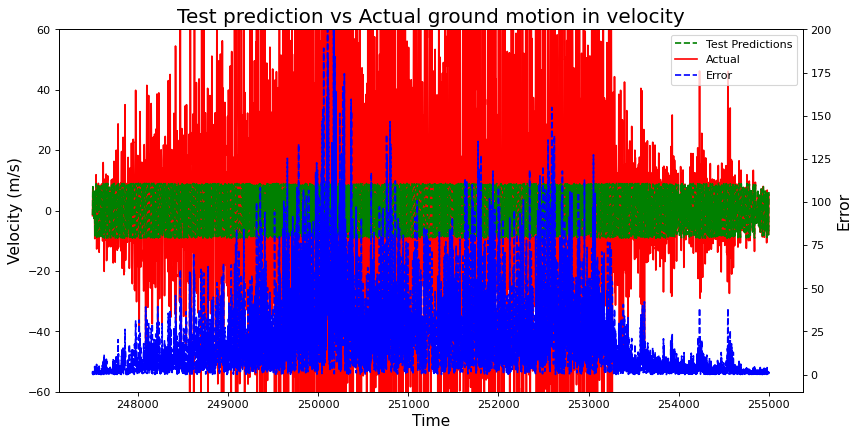

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=80)

Actuals = ax1.plot((test_results['Actuals'][247500:255000]),
                   color='red', linestyle='solid', label = 'Actual')
Train_Predictions = ax1.plot((test_results['Test Predictions'][247500:255000]),
                             color='green', linestyle='dashed', label= 'Test Predictions')
ax1.set_xlabel('Time',fontsize = 14)
ax1.set_ylabel('Velocity (m/s)',fontsize = 14)

ax2 = ax1.twinx()
Error = ax2.plot((test_results_difference['Actuals'][247500:255000]),
                 color='blue', linestyle='dashed', label = 'Error')
ax2.set_ylabel('Error',fontsize = 14)
ax1.set_ylim(-60,60)
ax2.set_ylim(-10,200)

lines = Train_Predictions + Actuals + Error
labels = [l.get_label() for l in lines]
ax2.legend(lines,labels)

plt.title('Test prediction vs Actual ground motion in velocity',fontsize = 18)

fig.savefig('Test prediction vs Actual ground motion in velocity_zoomed in.png')

## Loss 

In [22]:
def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(figsize=(12, 6), dpi=80)
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.savefig("Training and validation loss" )
    plt.show()
    return None

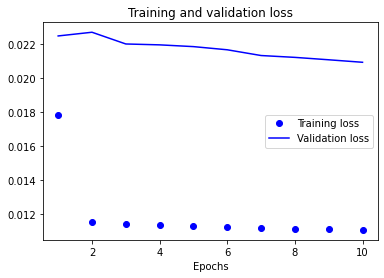

In [24]:
perf_plot(history)

## Root Mean Squared Error

In [23]:
def perf_plot_rmse(history, what = 'root_mean_squared_error'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(figsize=(12, 6), dpi=80)
    plt.plot(epochs, x, 'bo', label = "Training RMSE" )
    plt.plot(epochs, val_x, 'b', label = "Validation RMSE" )
    plt.title("Training and validation RMSE ")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.savefig("Training and validation RMSE" )
    plt.show()
    return None

In [24]:
perf_plot_rmse(history)

NameError: name 'history' is not defined